[View in Colaboratory](https://colab.research.google.com/github/miguelrq/GANs/blob/master/GAN-CIFAR10.ipynb)

In [1]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 15.7MB/s 


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5bfdc000 @  0x7f3c1dbc71c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [0]:
import argparse
import os
import numpy as np
import math

import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable



In [0]:
os.makedirs('images', exist_ok=True)


n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 32
channels = 3
sample_interval = 800

In [0]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [8]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs('../../data/CIFAR10', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../../data/CIFAR10', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [0]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [10]:
# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        
        batches_done = epoch * len(dataloader) + i
        
        if batches_done%300==0:
          print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))
        
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], 'images/%d.png' % batches_done, nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/782] [D loss: 0.690019] [G loss: 0.705832]
[Epoch 0/200] [Batch 300/782] [D loss: 0.357728] [G loss: 1.551662]
[Epoch 0/200] [Batch 600/782] [D loss: 0.907426] [G loss: 2.171534]
[Epoch 1/200] [Batch 118/782] [D loss: 0.501826] [G loss: 2.463974]
[Epoch 1/200] [Batch 418/782] [D loss: 0.353604] [G loss: 2.356310]
[Epoch 1/200] [Batch 718/782] [D loss: 0.418487] [G loss: 3.009448]
[Epoch 2/200] [Batch 236/782] [D loss: 0.316458] [G loss: 2.351212]
[Epoch 2/200] [Batch 536/782] [D loss: 0.282440] [G loss: 1.895329]
[Epoch 3/200] [Batch 54/782] [D loss: 0.407132] [G loss: 1.661868]
[Epoch 3/200] [Batch 354/782] [D loss: 0.369379] [G loss: 1.567303]
[Epoch 3/200] [Batch 654/782] [D loss: 0.576433] [G loss: 1.748914]
[Epoch 4/200] [Batch 172/782] [D loss: 0.526786] [G loss: 1.594826]
[Epoch 4/200] [Batch 472/782] [D loss: 0.425729] [G loss: 2.312602]
[Epoch 4/200] [Batch 772/782] [D loss: 0.441322] [G loss: 1.492947]
[Epoch 5/200] [Batch 290/782] [D loss: 0.392763] [G

In [16]:
!ls images/ -l . | egrep -c '^-'

196


In [0]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('images/*.png'): #assuming gif
    im=Image.open(filename)
    image_list.append(im)

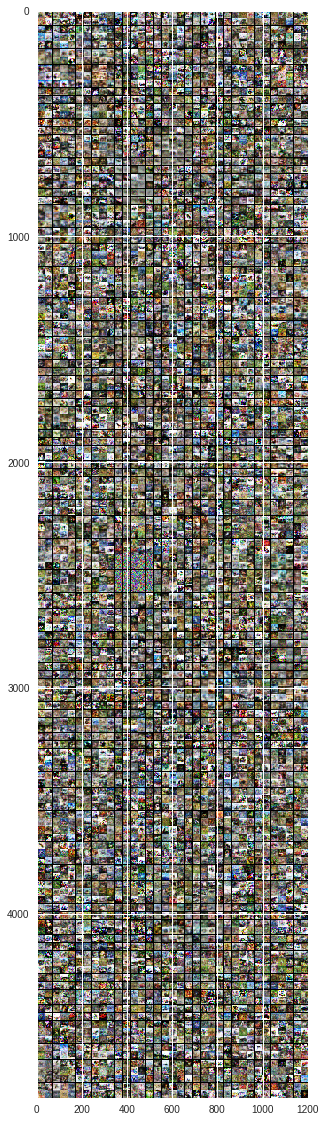

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def gallery(array, ncols=7):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array():      
    return np.array([np.array(img) for img in image_list])    

array = make_array()
result = gallery(array)
plt.figure(figsize=(13,20))
plt.imshow(result)
plt.show()

In [59]:
!ls ../../data/Fashionmnist/raw/

../../data/Fashionmnist/raw/t10k-labels-idx1-ubyte
